In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import glob
import matplotlib.pyplot as plt

##  Group vs. individual variance
For each data set seperately, determine the variance that is explained by group, subject and measurement noise, un L2Half models. 

Make a nice plot


In [6]:
# configs
dataset_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
logalpha_list = [6, 4, 6, 6, 0, 0, 8, 4]

In [7]:
# Load the product matrix and metadata vectors 
data = np.load("/home/UWO/ashahb7/Github/bayes_temp/L2reghalf_cov_matrix.npz", allow_pickle=True)
indices = []
for ds, la in zip(dataset_list, logalpha_list):
    indices.append(np.where((data['dataset_vec'] == ds) & (data['logalpha_vec'] == la))[0])
indices = np.concatenate(indices)
product_la = data['product_matrix'][np.ix_(indices, indices)]
dataset_vec_la = data['dataset_vec'][indices]
sub_vec_la = data['sub_vec'][indices]
part_vec_la = data['part_vec'][indices]

In [10]:
ds_var_decom_df = pd.DataFrame()
for dataset_name in dataset_list:
    print(f"\nDecomposing Variance for Dataset: {dataset_name}")
    subset_indices = np.where(dataset_vec_la == dataset_name)[0]
    product_subset = product_la[np.ix_(subset_indices, subset_indices)]
    dataset_subset = dataset_vec_la[subset_indices]
    sub_subset = sub_vec_la[subset_indices]
    part_subset = part_vec_la[subset_indices]

    # Solve
    df = rm.decompose_variance_scaled_from_SS(product_subset, dataset_subset, sub_subset, part_subset, single_scaling=True)
    ds_var_decom_df = pd.concat([ds_var_decom_df, df], ignore_index=True)


Decomposing Variance for Dataset: MDTB
The number of unique datasets is 1. Universal Variance (v_u) cannot be estimated. Returning v_g as v_u + v_d.
Bad pairs (cross-subject): 0.18%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%

Decomposing Variance for Dataset: Language
The number of unique datasets is 1. Universal Variance (v_u) cannot be estimated. Returning v_g as v_u + v_d.
Bad pairs (cross-subject): 9.74%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%

Decomposing Variance for Dataset: Social
The number of unique datasets is 1. Universal Variance (v_u) cannot be estimated. Returning v_g as v_u + v_d.
Bad pairs (cross-subject): 16.23%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-partition): 0.00%

Decomposing Variance for Dataset: WMFS
The number of unique datasets is 1. Universal Variance (v_u) cannot be estimated. Returning v_g as v_u + v_d.
Bad pairs (cross-subject): 1.46%
Bad pairs (cross-partition): 0.00%
Bad pairs (same-par

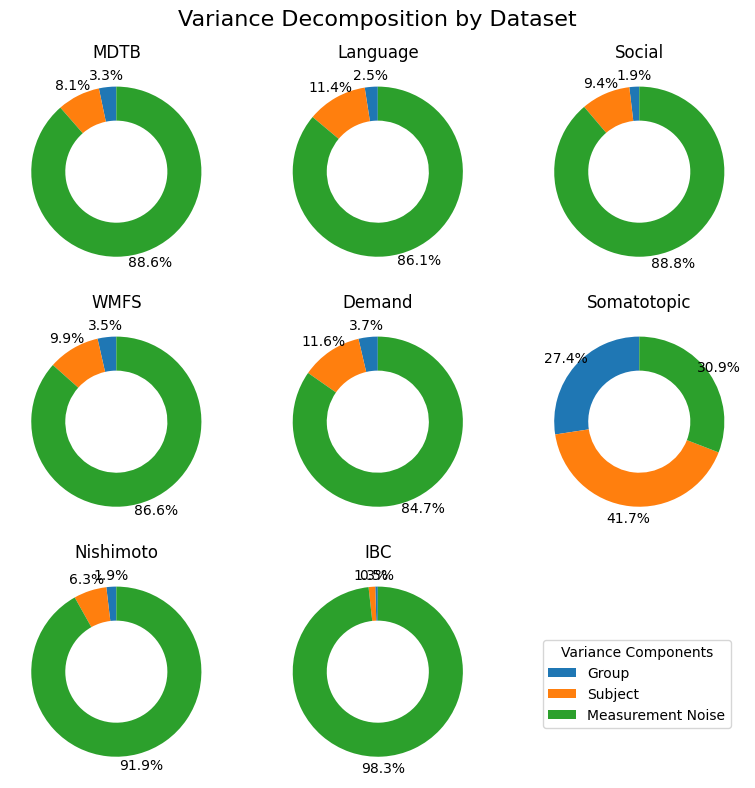

In [50]:
# Initialize an empty DataFrame to store mean percentages for each dataset
mean_percentages_list = []

# Loop through each dataset
for dataset_name in dataset_list:
    # Filter the data for the current dataset
    subset_df = ds_var_decom_df[ds_var_decom_df['train_dataset'] == dataset_name].copy().reset_index(drop=True)
    
    # Calculate the total variance for the current dataset
    subset_df['total_variance'] = subset_df['v_g'] + subset_df['v_s'] + subset_df['v_m']
    
    # Calculate the percentage of v_g, v_s, and v_m
    subset_df['v_g_percentage'] = (subset_df['v_g'] / subset_df['total_variance']) * 100
    subset_df['v_s_percentage'] = (subset_df['v_s'] / subset_df['total_variance']) * 100
    subset_df['v_m_percentage'] = (subset_df['v_m'] / subset_df['total_variance']) * 100
    
    # Calculate the mean percentages for the current dataset
    mean_percentages = subset_df[['v_g_percentage', 'v_s_percentage', 'v_m_percentage']].mean()
    mean_percentages.name = dataset_name  # Set the dataset name as the index
    
    # Append the result to the list
    mean_percentages_list.append(mean_percentages)

# Combine all mean percentages into a single DataFrame
mean_percentages = pd.DataFrame(mean_percentages_list, index=dataset_list)

# Plot pie charts for all datasets in one figure as subplots
fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Create a 3x3 grid of subplots
plt.suptitle('Variance Decomposition by Dataset', fontsize=16)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, dataset_name in enumerate(dataset_list):
    # Get the mean percentages for the current dataset
    percentages = mean_percentages.loc[dataset_name]
    
    # Create a donut chart in the corresponding subplot
    wedges, texts, autotexts = axes[i].pie(
        percentages,
        labels=None,  # Remove labels from the pie chart
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette()[:3],
        wedgeprops=dict(width=0.4)  # Adjust the width to create a donut chart
    )
    # Move percentages to the outer of the circles
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(10)
        autotext.set_position((1.9 * autotext.get_position()[0], 1.9 * autotext.get_position()[1]))
    
    axes[i].set_title(f'{dataset_name}', fontsize=12)

# Add a single legend for all subplots with a title
fig.legend(
    ['Group', 'Subject', 'Measurement Noise'],
    loc='upper right',
    bbox_to_anchor=(0.95, 0.2),
    fontsize=10,
    title='Variance Components'
)

# Remove the last unused subplot
fig.delaxes(axes[-1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()